In [2]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
import time
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import numpy as np
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from warnings import warn
import os

##### Data preparation

In [3]:
# import both datasets

data_pre = pd.read_excel('Final Dataset.xlsx', sheet_name='Pre COVID', index_col=0)
data_post = pd.read_excel('Final Dataset.xlsx', sheet_name='Post COVID', index_col=0)

exogenous_pre = data_pre.iloc[:, 102:]
exogenous_post = data_post.iloc[:, 102:]

# create a list of company tickers and number of companies
companies = ['PKO', 'PZU', 'PGE', 'KGH', 'PKN', 'LLP', 'PEO', 'CDR', 'ENE', 'TPE',
            'AMC', 'CCC', 'BDX', 'CPS', 'ALR', 'JSW', 'ACP', 'CAR', 'SPL', 'PEP',
            'KRU', 'NEU', 'ERB', 'ATD', 'DAT', 'ZMT', 'KTY', 'ABE', 'MRB', 'UNI',
            'WIG', 'WIG20', 'mWIG40', 'sWIG80']

num_of_companies = len(companies)

In [4]:
# create a function to split the data
def split_data(data, num_of_companies, companies):

    # initiate a ditionary to store data for each company separetly
    data_companies = {}

    data = data.iloc[1:, :] 

    # split the data into the companies
    for i in range(num_of_companies):

        # get Close, Volume and Trading range
        df = data.iloc[:, i*3:i*3+3]

        # get rid of company ticker from the column names
        df.columns = ['Close', 'Volume', 'Trading range']

        # save the data into the dictionary
        data_companies[companies[i]] = df
    
    return data_companies

In [5]:
def moving_average(data_companies, window1, window2, window3):

    for company, data in data_companies.items():

        data[f'{window1}-Day MA'] = data['Close'].rolling(window=window1).mean()

        data[f'{window2}-Day MA'] = data['Close'].rolling(window=window2).mean()

        data[f'{window3}-Day MA'] = data['Close'].rolling(window=window3).mean()

        data_companies[company] = data.dropna()

    return data_companies

In [6]:
def check_stationarity(data_companies):
    """
    Checks the stationarity of data for each company and performs differencing up to 3 times if needed.

    Parameters:
        data_companies (dict): Dictionary where keys are company names and values are DataFrames of their variables.

    Returns:
        dict: Dictionary with updated variables ensuring stationarity where possible.
    """
    for company, variables in data_companies.items():
        for col in variables.columns:
            differencing_count = 0  # Track number of differencing attempts
            p_value = adfuller(variables[col])[1]  # Initial p-value

            # Perform differencing up to 3 times if non-stationary
            while p_value > 0.05 and differencing_count < 3:
                variables[col] = variables[col].diff().bfill()  # Perform differencing
                differencing_count += 1
                p_value = adfuller(variables[col])[1]  # Recalculate p-value

            # Notify if still non-stationary after 3 differencing attempts
            if p_value > 0.05:
                print(f"{company} {col} remains non-stationary after 3 differencing attempts.")

        # Update the DataFrame, removing the rows with NaN values caused by differencing
        data_companies[company] = variables.iloc[3:, :]  # Drop the first 3 rows to handle NaNs if differencing was performed
    
    return data_companies

In [7]:
def exo_stationarity(exogenous):
    
    exogenous = exogenous.iloc[1:, :]

    for col in exogenous.columns:

        # Check if the data is stationary
        p_value = adfuller(exogenous[col])[1]

        # If p-value > 0.05, data is non-stationary and needs differencing
        if p_value > 0.05:

            # Perform differencing and fill the data backwords to replace NaNs (will get rid of first row later)
            exogenous.loc[:, col] = exogenous[col].diff().bfill()
            p_value = adfuller(exogenous[col])[1]

            # Check again after the differencing
            if p_value > 0.05:
                
                print(f"{col} is non-stationary after the differencing.")

    exogenous = exogenous.iloc[1:, :]
    
    return exogenous

In [8]:
def data_merging(company_data, exogenous_data):
    # Merge the company data with the exogenous data
    for company, variables in company_data.items():
        company_data[company] = pd.concat([variables, exogenous_data], axis=1).loc[variables.index]
    
    return company_data

In [9]:
def normalization(data_companies):
    # Normalize the data
    for company, variables in data_companies.items():
        scaler = StandardScaler()

        variables_scaled = pd.DataFrame(scaler.fit_transform(variables))
        variables_scaled.columns = variables.columns
        variables_scaled.index = variables.index

        data_companies[company] = variables_scaled
    
    return data_companies

In [10]:
exogenous_pre = exogenous_pre[['Close_1YBond', 'Close_10YBond', 'Close_EUR/PLN', 'Close_Gold', 'Close_Oil', 'Close_USD/PLN', 'Close_VIX']]
exogenous_post = exogenous_post[['Close_1YBond', 'Close_10YBond', 'Close_EUR/PLN', 'Close_Gold', 'Close_Oil', 'Close_USD/PLN', 'Close_VIX']]

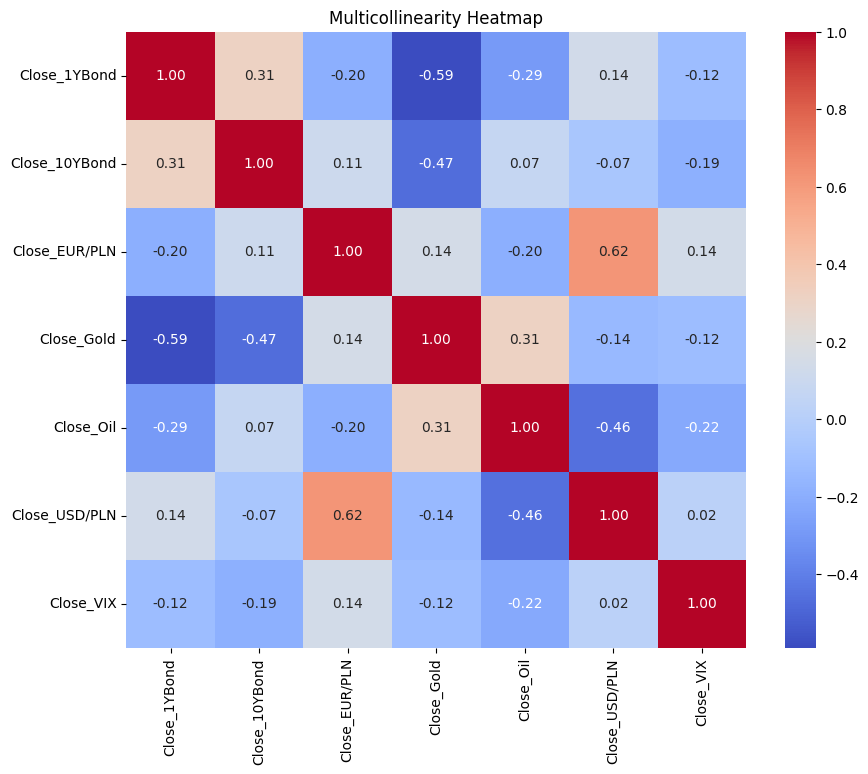

In [11]:
# Compute the correlation matrix
correlation_matrix = exogenous_pre.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Set the title
plt.title('Multicollinearity Heatmap')
plt.show()

In [12]:
exogenous_pre = exogenous_pre[['Close_1YBond', 'Close_10YBond', 'Close_EUR/PLN', 'Close_Oil', 'Close_VIX']]

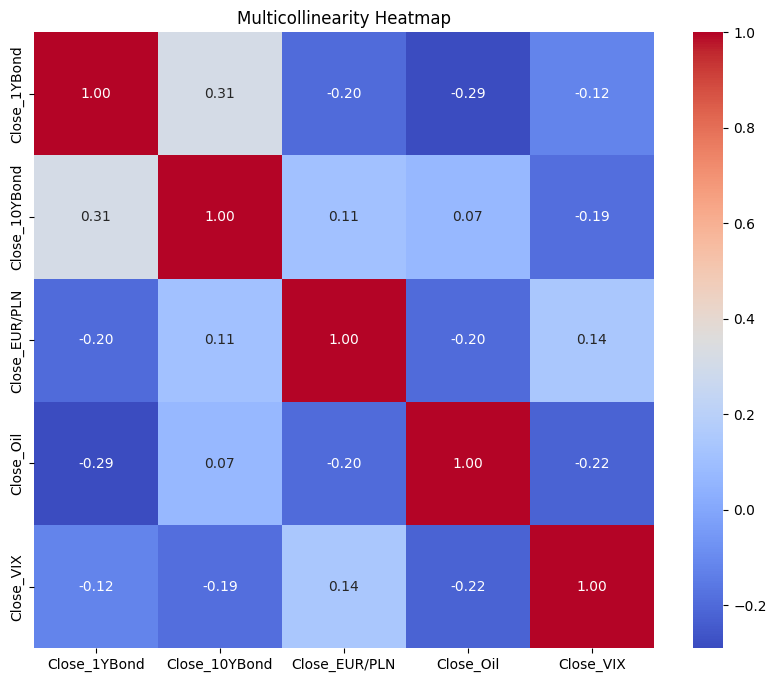

In [13]:
# Compute the correlation matrix
correlation_matrix = exogenous_pre.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Set the title
plt.title('Multicollinearity Heatmap')
plt.show()

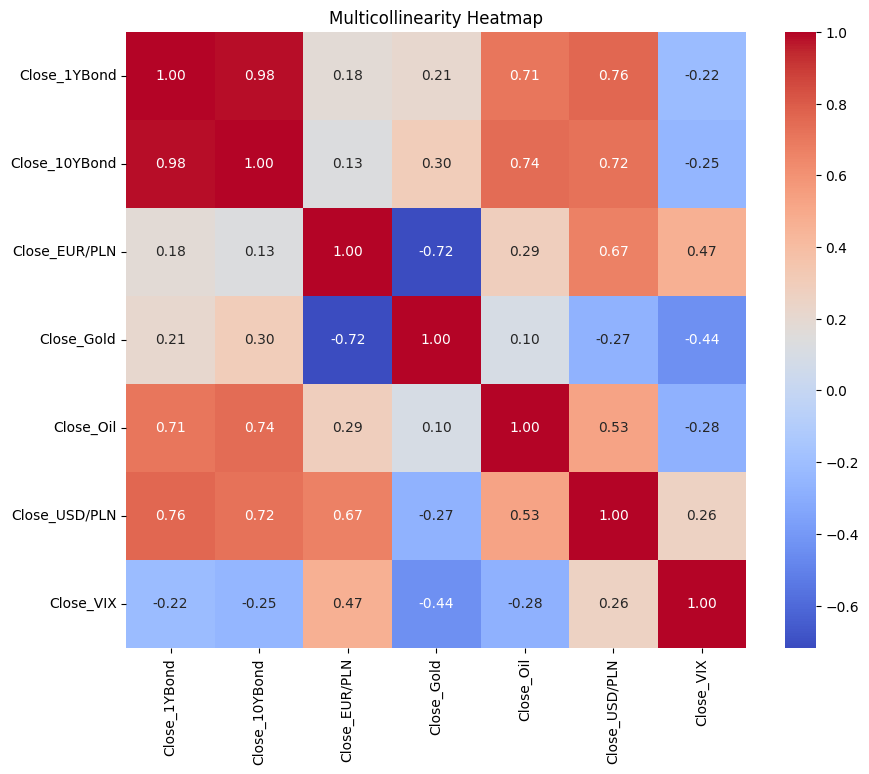

In [14]:
# Compute the correlation matrix
correlation_matrix = exogenous_post.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Set the title
plt.title('Multicollinearity Heatmap')
plt.show()

In [15]:
exogenous_post = exogenous_post[['Close_1YBond', 'Close_Gold', 'Close_VIX']]

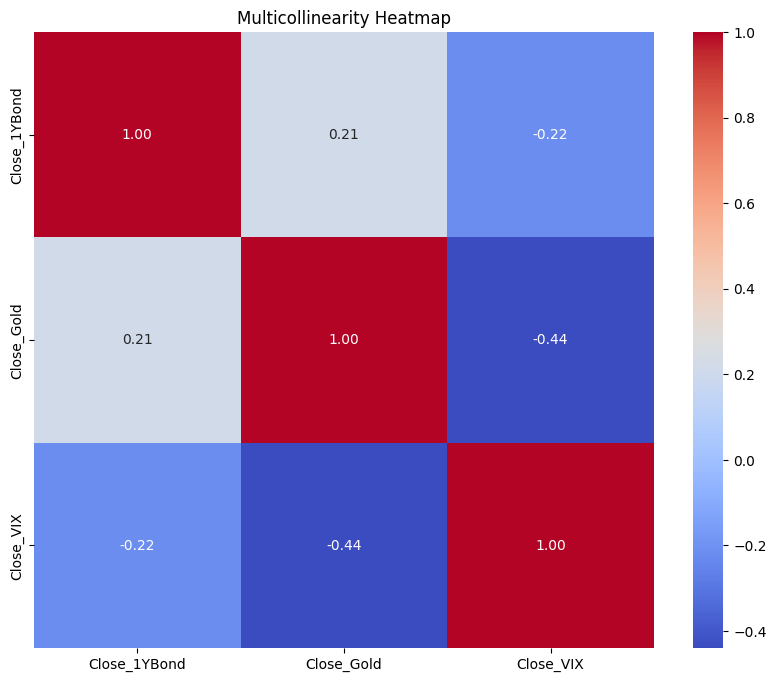

In [16]:
# Compute the correlation matrix
correlation_matrix = exogenous_post.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Set the title
plt.title('Multicollinearity Heatmap')
plt.show()

In [17]:
# ececute the functions 

data_companies_pre = split_data(data_pre, num_of_companies, companies)
data_companies_post = split_data(data_post, num_of_companies, companies)

data_companies_pre = moving_average(data_companies_pre, 30, 60, 120)
data_companies_post = moving_average(data_companies_post, 30, 60, 120)

data_companies_pre = check_stationarity(data_companies_pre)
data_companies_post = check_stationarity(data_companies_post)

exogenous_pre = exo_stationarity(exogenous_pre)
evogenous_post = exo_stationarity(exogenous_post)

data_companies_pre = data_merging(data_companies_pre, exogenous_pre)
data_companies_post = data_merging(data_companies_post, exogenous_post)

data_companies_pre = normalization(data_companies_pre)
data_companies_post = normalization(data_companies_post)

In [17]:
data_companies_pre['PKO'].head(10)

,Close,Volume,Trading range,30-Day MA,60-Day MA,120-Day MA,Close_1YBond,Close_10YBond,Close_EUR/PLN,Close_Oil,Close_VIX
2015-06-23,-0.362510,-0.565163,-0.465050,-2.407781,-0.731185,-0.249981,-0.125166,-0.493358,-1.600568,1.190520,-0.682468
2015-06-24,0.662177,0.264528,-0.133752,-1.479652,-0.580061,0.318563,1.242152,0.735577,-1.810370,-0.664788,-0.425247
2015-06-25,0.406009,0.679085,-0.082776,-1.320316,-0.545187,-1.374980,-0.694882,-0.180538,-1.624228,-0.512421,-0.257494
2015-06-26,-1.267657,0.838027,0.579831,-1.495586,-0.760248,-0.370952,-1.236112,1.048397,-1.653338,-0.064278,-0.255257
2015-06-29,-1.284733,0.725750,3.485128,-1.874008,-0.978214,-0.939496,3.464044,2.746562,-1.461890,-1.166709,0.825072
2015-06-30,0.628024,0.506139,0.146590,-1.587203,-0.928807,-0.419337,-0.410024,-0.895555,-1.370115,1.020226,0.686396
2015-07-01,-0.652842,-0.033342,0.605317,-1.814258,-1.036338,0.197597,-0.381539,-0.381636,-1.346449,-2.251218,0.207741
2015-07-02,-0.840700,2.563837,0.452413,-2.212596,-1.184555,2.278239,-0.296081,-1.141341,-1.424322,-0.028426,0.364311
2015-07-03,-0.430824,-0.673124,-0.312141,-2.272347,-1.196180,0.899212,-0.125166,-1.051964,-1.372263,-0.001539,0.364311
2015-07-06,0.337695,-0.399545,0.146590,-1.535419,-1.222335,0.112921,0.302121,0.556823,-1.232443,-3.945197,0.413518


In [18]:
data_companies_post['PKO'].head(10)

,Close,Volume,Trading range,30-Day MA,60-Day MA,120-Day MA,Close_1YBond,Close_Gold,Close_VIX
2020-09-25,-0.272749,-0.046705,-1.194675,-0.961138,-0.843304,-0.175501,-0.215676,-0.606142,1.185269
2020-09-28,1.209640,0.331108,-0.340601,-0.709492,-0.722454,0.931225,0.057151,0.768126,1.150515
2020-09-29,-0.074319,0.459703,-1.403838,-0.653322,-0.687472,-0.480505,-0.043896,1.110349,1.165148
2020-09-30,0.252508,0.513165,-0.706631,-0.475822,-0.646129,1.140372,0.491652,-0.402942,1.183440
2020-10-01,-0.179368,-0.848518,-1.194678,-0.430885,-0.660440,-0.018642,-0.165152,1.078266,1.243803
2020-10-02,0.229162,-0.915914,-0.619482,-0.399429,-0.665210,0.295076,-0.559235,-0.477805,1.413915
2020-10-05,0.661040,-0.561333,-1.212106,-0.332024,-0.595245,0.347363,-0.235885,0.618399,1.474278
2020-10-06,0.906158,1.203549,-0.079150,-0.064651,-0.434643,1.628374,0.431024,-0.648917,1.752312
2020-10-07,0.089096,0.022935,-1.124956,-0.100600,-0.507788,-0.036070,-0.124734,-0.975101,1.492570
2020-10-08,-0.506194,-0.307219,-0.898367,-0.134303,-0.542771,-0.384646,-0.559235,0.228043,1.181611


##### Modeling

In [19]:
# Define a function to test different p and q
def test_arima_orders(y, X, max_p=5, max_q=5):
    results = []
    
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:

                # Suppress warnings about stationarity (only do this if you are sure about your data)
                warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
                warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
                warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge. Check mle_retvals")
                warnings.filterwarnings("ignore", message="ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.")
                    

                # Fit ARIMAX model
                model = ARIMA(y, exog=X, order=(p, 0, q))  # Assuming d=0
                fit = model.fit()
                
                # Ljung-Box Test
                lb_test = acorr_ljungbox(fit.resid, lags=[10], return_df=True)
                p_value = lb_test['lb_pvalue'].values[0]  # Get p-value for lag 10
                
                # Store results
                results.append((p, q, fit.aic, p_value))
            except ConvergenceWarning:
                continue
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results, columns=['p', 'q', 'AIC', 'Ljung-Box p-value'])

    results_df = results_df[results_df['Ljung-Box p-value'] > 0.05]


    return (results_df.sort_values(by='AIC'))

In [20]:
# Define a function that will meke the predictions
def rolling_prediction(data, company, cutoff_date, train_index, test_index):
    # start timer to see duration
    start_time = time.time()

        # train test split
    X_train = data.iloc[:,1:][data.index < cutoff_date].values
    X_test = data.iloc[:,1:][data.index >= cutoff_date].values
    y_train = data['Close'][data.index < cutoff_date].values
    y_test = data['Close'][data.index >= cutoff_date].values

    X_train = pd.DataFrame(X_train, index=train_index)
    y_train = pd.Series(y_train, index=train_index)
    X_test = pd.DataFrame(X_test, index=test_index)
    y_test = pd.Series(y_test, index=test_index)

    # thest the optimal p and q
    p_q_test = test_arima_orders(y_train, X_train, max_p=10, max_q=10)
    print(p_q_test.head(5))
    p = p_q_test.iloc[0,0]
    q = p_q_test.iloc[0,1]


    # Fit the ARIMAX model with selected p and q
    model_selected = ARIMA(y_train, exog=X_train, order=(p, 0, q))  # ARIMA with exogenous variables
    fit_selected = model_selected.fit(method_kwargs={"maxiter": 1000})

    # Print the summary to check model details
    print(fit_selected.summary())


    # # convert the data to dataframes

    y_train = pd.DataFrame(y_train, index=train_index)
    y_test = pd.DataFrame(y_test, index=test_index)

    # Ensure y_train is a 1D array before creating a pandas Series
    y_train_temp = pd.Series(y_train.iloc[:, 0].values, index=train_index)  # Adjust the start date and frequency as per your data
    

    # If X_train is a numpy array, convert it to DataFrame
    if isinstance(X_train, np.ndarray):
        X_train = pd.DataFrame(X_train)

    # Fit the ARIMAX model with the current data (ARIMAX(2,1,5)) for the first prediction
    model = ARIMA(y_train_temp, exog=X_train[:len(y_train_temp)], order=(p, 1, q))
    fit = model.fit(method_kwargs={"maxiter": 500})

    # Initialize empty lists to store the results
    predictions = []
    actuals = []

    # Loop through the test set
    for i in range(len(X_test)):
        # If it's the first prediction, we only need the first exogenous value
        if i == 0:
            forecast = fit.predict(start=len(y_train_temp), end=len(y_train_temp), exog=X_test.iloc[i, :].values.reshape(1, -1))
        else:
            # For subsequent predictions, add the forecasted value to y_train_temp
            y_train_temp = pd.concat([y_train_temp, pd.Series(forecast, index=[y_test.index[i-1]])])

            # Also, collect the exogenous variables for the current prediction
            exog_values = X_test.iloc[:i+1, :].values  # Collect exogenous variables up to current point
            
            forecast = fit.predict(start=len(y_train_temp), end=len(y_train_temp), exog=exog_values)
        
        # Store the prediction and the actual value
        predictions.append(forecast.iloc[0])  # forecast is an array, so we take the first element
        actuals.append(y_test.iloc[i, 0])  # Get the actual value from y_test

    # Create a DataFrame with predictions and actual values

    
    end_time = time.time()  # End the timer
    execution_time = end_time - start_time  # Calculate the difference
    print(f"Execution time: {execution_time:.4f} seconds")
    return predictions


##### Pre COVID

In [22]:
cutoff_date = "2019-01-01"

train_index = data_companies_pre['PKO'].iloc[:,1:][data_companies_pre['PKO'].index < cutoff_date].index
test_index = data_companies_pre['PKO']['Close'][data_companies_pre['PKO'].index >= cutoff_date].index

warnings.filterwarnings("ignore")


In [ ]:
# perform the predictions
file_path = 'ARIMAX_results.xlsx'
sheet_name = 'Pre_COVID'

# Check if the file exists and contains the required sheet
if os.path.exists(file_path):
    with pd.ExcelFile(file_path) as xls:
        if sheet_name in xls.sheet_names:
            results_pre = pd.read_excel(file_path, sheet_name=sheet_name, index_col=0)
        else:
            # Create a new sheet with an empty DataFrame
            results_pre = pd.DataFrame(columns=companies, index=test_index)
            with pd.ExcelWriter(file_path, engine="openpyxl", mode="a") as writer:
                results_pre.to_excel(writer, sheet_name=sheet_name)
else:
    # Create a new file with the required sheet
    results_pre = pd.DataFrame(columns=companies, index=test_index)
    results_pre.to_excel(file_path, sheet_name=sheet_name)

for company in companies:
    # Reload the file in each iteration to prevent data loss
    results_pre = pd.read_excel(file_path, sheet_name=sheet_name, index_col=0)

    # Check if there are NaN values for the company
    if results_pre[company].isnull().values.any():
        print(f'--------------------Modeling for {company} in pre-COVID period---------------------')

        # Run rolling prediction (returns a list)
        predictions = rolling_prediction(data_companies_pre[company], company, cutoff_date, train_index, test_index)

        # Ensure predictions length matches the expected index length
        if len(predictions) != len(results_pre):
            print(f"Warning: Mismatch in prediction length for {company}. Expected {len(results_pre)}, got {len(predictions)}.")
            continue  # Skip saving if the length is incorrect

        # Update results and save immediately
        results_pre[company] = predictions  # Store the list in the DataFrame column
        with pd.ExcelWriter(file_path, engine="openpyxl", mode="a") as writer:
            results_pre.to_excel(writer, sheet_name=sheet_name)

    else: 
        print(f'{company} already modeled')


In [1]:
results_pre

NameError: name 'results_pre' is not defined

##### Post COVID

In [19]:
cutoff_date = "2023-11-28"

train_index = data_companies_post['PKO'].iloc[:,1:][data_companies_post['PKO'].index < cutoff_date].index
test_index = data_companies_post['PKO']['Close'][data_companies_post['PKO'].index >= cutoff_date].index

warnings.filterwarnings("ignore")

In [ ]:
# perform the predictions
file_path = 'ARIMAX_results.xlsx'
sheet_name = 'Post_COVID'

# Check if the file exists and contains the required sheet
if os.path.exists(file_path):
    with pd.ExcelFile(file_path) as xls:
        if sheet_name in xls.sheet_names:
            results_post = pd.read_excel(file_path, sheet_name=sheet_name, index_col=0)
        else:
            # Create a new sheet with an empty DataFrame
            results_post = pd.DataFrame(columns=companies, index=test_index)
            with pd.ExcelWriter(file_path, engine="openpyxl", mode="a") as writer:
                results_post.to_excel(writer, sheet_name=sheet_name)
else:
    # Create a new file with the required sheet
    results_post = pd.DataFrame(columns=companies, index=test_index)
    results_post.to_excel(file_path, sheet_name=sheet_name)

for company in companies:
    # Reload the file in each iteration to prevent data loss
    results_post = pd.read_excel(file_path, sheet_name=sheet_name, index_col=0)

    # Check if there are NaN values for the company
    if results_post[company].isnull().values.any():
        print(f'--------------------Modeling for {company} in post-COVID period---------------------')

        # Run rolling prediction (returns a list)
        predictions = rolling_prediction(data_companies_post[company], company, cutoff_date, train_index, test_index)

        # Ensure predictions length matches the expected index length
        if len(predictions) != len(results_post):
            print(f"Warning: Mismatch in prediction length for {company}. Expected {len(results_post)}, got {len(predictions)}.")
            continue  # Skip saving if the length is incorrect

        # Update results and save immediately
        results_post[company] = predictions  # Store the list in the DataFrame column
        with pd.ExcelWriter(file_path, engine="openpyxl", mode="a") as writer:
            results_post.to_excel(writer, sheet_name=sheet_name)

    else: 
        print(f'{company} already modeled')


In [ ]:
results_post